## Define the categories

In [2]:
target_class = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

## Load the data sets

## split the comment and the category from the test

In [3]:
import numpy as np

def get_XY(data,count_pos,count_neg):
    numpy_array = data.as_matrix()
    X = numpy_array[:,1]
    Y = []
    for i,d in enumerate(numpy_array):
        cur_y = []
        notToxic = True
        if d[2] == 1:
            cur_y.append(0)
            notToxic = False
        if d[3] == 1:
            cur_y.append(1)
            notToxic = False
        if d[4] == 1:
            cur_y.append(2)
            notToxic = False
        if d[5] == 1:
            cur_y.append(3)
            notToxic = False
        if d[6] == 1:
            cur_y.append(4)
            notToxic = False
        if d[7] == 1:
            cur_y.append(5)
            notToxic = False
        if notToxic:
            count_pos=count_pos+1
        else:
            count_neg=count_neg+1
        Y.append(cur_y)
    return X,Y,count_pos,count_neg

import pandas as pd
data = pd.read_csv('data.csv')
count_pos=0
count_neg=0
X,y,count_pos,count_neg = get_XY(data,count_pos,count_neg)
print("The number of non-toxic tweets are",count_pos)
print("The number of toxic tweets are",count_neg)


The number of non-toxic tweets are 143346
The number of toxic tweets are 16225


# Plot average precison recall curve

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_average_pr_curve(Y_test,y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    n_classes=6
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    plt.show()
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(target_class[i], average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve to multi-class')
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


    plt.show()

## Split the data into train and test tests

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
Y = MultiLabelBinarizer().fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)


In [6]:
d={}
for y in Y:
    c= "".join(str(x) for x in y)
    if c not in d:
        d[c]=1;
    else:
        d[c]+=1
print(d)

{'000000': 143346, '111010': 989, '100000': 5666, '101011': 618, '101010': 3800, '101000': 1758, '100100': 113, '100010': 1215, '101111': 56, '000010': 301, '001000': 317, '111000': 158, '101110': 131, '111011': 265, '111111': 31, '100011': 134, '100001': 136, '001010': 181, '111001': 6, '111110': 64, '000001': 54, '101001': 35, '000100': 22, '001011': 18, '110000': 41, '110010': 14, '110001': 3, '001100': 2, '100110': 16, '000011': 28, '111100': 4, '110011': 7, '101100': 11, '110100': 11, '000110': 3, '100111': 3, '100101': 7, '001110': 2, '001001': 3, '110110': 1, '110101': 1}


## Import the scikit learn packages and perform text classification

# Linear SVM classifier

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt



from sklearn.svm import LinearSVC

classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC()))])

classifier.fit(X_train, Y_train)
predicted = classifier.predict(X_test)
y_score = classifier.decision_function(X_test)
#precision, recall, _ = precision_recall_curve(Y_test, y_score)

Average precision score, micro-averaged over all classes: 0.80


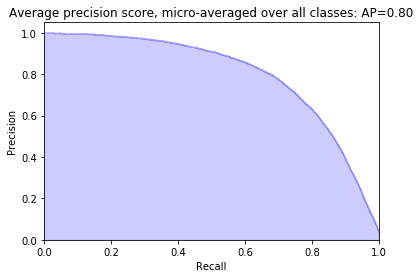

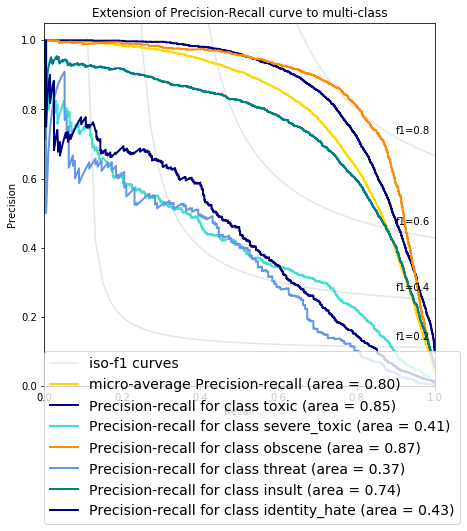

In [8]:
plot_average_pr_curve(Y_test,y_score)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, predicted)

In [ ]:
predicted[0]
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(Y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
y_score = classifier.decision_function(X_test)
print(y_score)


In [ ]:
from sklearn.metrics import average_precision_score
average_precision_score(Y_test, y_score)  

# Naive Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
mnb=MultinomialNB()

from sklearn.svm import LinearSVC


#Y_binary_train=[]
#Y_binary_test=[]
#for i in Y_train:
# Y_binary_train.append(1-i[0])

#for i in Y_test:
# Y_binary_test.append(1-i[0])


model = make_pipeline(TfidfVectorizer(), mnb)

print(X_train[0])
print(Y_train[0])

model.fit(X_train, Y_train)
predicted = model.predict(X_test)
y_score = model.score(X_test, Y_test)
print(y_score)
print(precision_score(Y_test, predicted, average="micro") )
average_precision = average_precision_score(Y_test, predicted)
precision, recall, _ = precision_recall_curve(Y_test, predicted)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# Decision tree classifier

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
dt=DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5);
estimator = make_pipeline(TfidfVectorizer(),dt)
estimator.fit(X_train, Y_binary_train)
dtree_predictions = estimator.predict(X_test)
 
print(X_train[0])
print(X_test[0])
print(Y_train[0])

print(Y_test[0])
print(Y_binary_test[0])

#print(TfidfVectorizer("Ass man"))
docs_new = ['I love you','hang yourself']
#X_new_counts = count_vect.transform(docs_new)
#X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = estimator.predict(X_test)
#print(predicted)
#print(estimator.predict("Ass man"))
y_score = estimator.score(X_test, Y_binary_test)
print(y_score)
print(accuracy_score(Y_binary_test,dtree_predictions))
print(confusion_matrix(Y_binary_test,predicted))
precision, recall, _ = precision_recall_curve(Y_binary_test, predicted)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

# Tokenizer that builds a dictionary and one-hot representation of words

In [28]:
import json
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer

# only work with the 3000 most popular words found in our dataset
max_words = 3000
train_x=X_train
train_y=Y_train
# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index
# Let's save this out so we can use it later
with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)


def convert_text_to_index_array(text):
    # one really important thing that `text_to_word_sequence` does
    # is make all texts the same length -- in this case, the length
    # of the longest text in the set.
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

# now we have a list of all tweets converted to index arrays.
# cast as an array for future usage.
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')
# treat the labels as categories
print(train_y[0])

[0 0 0 0 0 0]


# Model structure of the Neural Network

In [106]:
import numpy as np

import json
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
weight={0:1.,1:0.}
model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

model.fit(train_x, train_y,
  batch_size=32,
  epochs=5,
  verbose=1,
  validation_split=0.1,
  shuffle=True)
#evalSentence="I love you"
#for i in X_test:
 #testArr = convert_text_to_index_array(str(i))
 #input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in
 #pred = model.predict(input)
 #print(pred)

 	#history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=max_epochs, callbacks=callbacks)
    # and print it for the humons


Train on 86167 samples, validate on 9575 samples
Epoch 1/5
86167/86167 [==============================] - 117s 1ms/step - loss: 0.2975 - acc: 0.9351 - val_loss: 0.2674 - val_acc: 0.9835
Epoch 2/5
86167/86167 [==============================] - 111s 1ms/step - loss: 0.2757 - acc: 0.9631 - val_loss: 0.2669 - val_acc: 0.9830
Epoch 3/5
86167/86167 [==============================] - 112s 1ms/step - loss: 0.2606 - acc: 0.9451 - val_loss: 0.2720 - val_acc: 0.8845
Epoch 4/5
86167/86167 [==============================] - 118s 1ms/step - loss: 0.2497 - acc: 0.9326 - val_loss: 0.2809 - val_acc: 0.9509
Epoch 5/5
86167/86167 [==============================] - 110s 1ms/step - loss: 0.2412 - acc: 0.9253 - val_loss: 0.2908 - val_acc: 0.8871


In [193]:
dum=[]
pred=[]
precision=[]
recall=[]

In [226]:
dum6=[]
pred6=[]
for i in range(86167):
 testArr = convert_text_to_index_array(str(X_train[i]))
 input = tokenizer.sequences_to_matrix([testArr], mode='binary')
 d=list(Y_train[i])
 dum6.append(d[5])
    # predict which bucket your input belongs in
 pr = model.predict(input)
 for i in pr:
  pred6.append(i[5])
 #print(dum[i])
 #print(pr.tolist())
dum.append(dum6)
pred.append(pred6) 

In [158]:
pred1

[0.76513129,
 0.97132462,
 0.98632401,
 0.84781885,
 0.78764778,
 0.51869714,
 0.77220172,
 0.49627155,
 0.70378649,
 0.98140395,
 0.48114181,
 0.54361171,
 0.65230036,
 0.9571628,
 0.9683159,
 0.54914218,
 0.82240182,
 0.40047413,
 0.94861156,
 0.73842824,
 0.73655468,
 0.9553268,
 0.27164581,
 0.78116083,
 0.99952507,
 0.80113012,
 0.71755302,
 0.66448361,
 0.8701368,
 0.5920558,
 0.62139994,
 0.46242726,
 0.47119579,
 0.56685179,
 0.68512636,
 0.8363694,
 0.45858738,
 0.72568989,
 0.94773775,
 0.9812476,
 0.93610507,
 0.3430993,
 0.88516748,
 0.62779069,
 0.30144534,
 0.98652411,
 0.59990984,
 0.6745221,
 0.66326433,
 0.951487,
 0.60404903,
 0.93832988,
 0.78914988,
 0.72100323,
 0.59168839,
 0.93459427,
 0.57098335,
 0.36644623,
 0.9014008,
 0.9997111,
 0.9949823,
 0.92990255,
 0.40094134,
 0.97188479,
 0.36852571,
 0.8730703,
 0.99487126,
 0.43311659,
 0.62343532,
 0.28072593,
 0.86563313,
 0.34576052,
 0.52530342,
 0.98101097,
 0.63499248,
 0.5351885,
 0.55248266,
 0.4561131,
 0.

In [227]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

pr, rc, _ = precision_recall_curve(dum6,pred6)
average_precision = average_precision_score(dum6, pred6)

precision.append(pr)
recall.append(rc)

In [228]:
print(average_precision)

0.509209735901


In [229]:

len(precision)
len(recall)

6

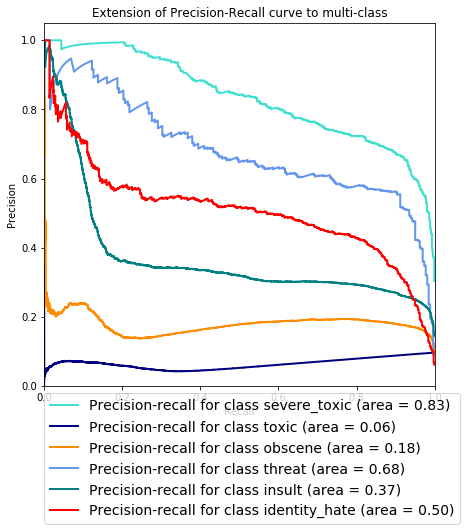

In [235]:
 from itertools import cycle
    # setup plot details
n_classes=6
target_class=["severe_toxic","toxic","obscene","threat","insult","identity_hate"]
average_precision=[0.8345,0.064,0.18,0.68,0.37,0.50]
plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []



colors = cycle(['turquoise','navy','darkorange','cornflowerblue','teal','red'])
for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(target_class[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [253]:
dumm=[]
pred=[]
y_score=[]
for i in range(86167):
 testArr = convert_text_to_index_array(str(X_train[i]))
 input = tokenizer.sequences_to_matrix([testArr], mode='binary')

    # predict which bucket your input belongs in
 pr = model.predict(input)
 y_score.append(pr)


In [251]:
pred[:,1]

TypeError: list indices must be integers or slices, not tuple

In [237]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    
    precision[i], recall[i], _ = precision_recall_curve(dumm[i],
                                                        pred[:, i])
    average_precision[i] = average_precision_score(dumm[i], pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(dumm.ravel(),
    pred.ravel())
average_precision["micro"] = average_precision_score(dumm, pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

TypeError: list indices must be integers or slices, not tuple

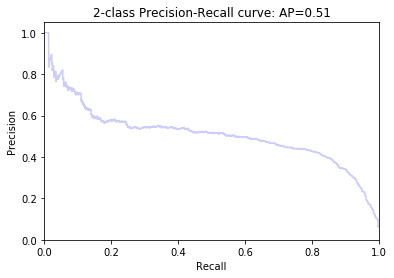

In [141]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
y_true = np.array(dum1)
y_scores = np.array(pred1)
precision, recall, thresholds = precision_recall_curve(
 y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_true,y_scores)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2,
 #                color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [131]:
print(precision)

[ 0.21341463  0.20858896  0.20987654  0.21118012  0.2125      0.21383648
  0.21518987  0.21656051  0.21794872  0.21935484  0.22077922  0.22222222
  0.22368421  0.22516556  0.22666667  0.22818792  0.22972973  0.23129252
  0.23287671  0.23448276  0.23611111  0.23776224  0.23943662  0.24113475
  0.24285714  0.24460432  0.24637681  0.24817518  0.25        0.25185185
  0.25373134  0.2556391   0.25757576  0.25954198  0.26153846  0.26356589
  0.265625    0.26771654  0.26984127  0.272       0.27419355  0.27642276
  0.27868852  0.28099174  0.28333333  0.28813559  0.29059829  0.29310345
  0.29565217  0.29824561  0.30088496  0.30357143  0.30630631  0.30909091
  0.31192661  0.31481481  0.31775701  0.32075472  0.32380952  0.32692308
  0.33009709  0.33333333  0.33663366  0.34        0.34343434  0.34693878
  0.35051546  0.35416667  0.35789474  0.36170213  0.3655914   0.36956522
  0.37362637  0.37777778  0.38202247  0.38636364  0.3908046   0.39534884
  0.4         0.4047619   0.40963855  0.41463415  0

In [ ]:
evalSentence="I love you"
testArr = convert_text_to_index_array(str(X_test[0]))
input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in
pred = model.predict(input)
print(pred)
    # and print it for the humons
print(X_test[0])
print(evalSentence)

In [ ]:
print(train_x[600])

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
dt=DecisionTreeClassifier();
bagging = BaggingClassifier(dt)
estimator = make_pipeline(TfidfVectorizer(),bagging)
estimator.fit(X_train, Y_train)
#dtree_predictions = estimator.predict(X_test)
#y_score = estimator.score(X_test, Y_test)
#print(y_score)


ValueError: bad input shape (95742, 6)

# Ensemble of decision trees

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
clf = RandomForestClassifier(n_estimators=2)

estimator = make_pipeline(TfidfVectorizer(),clf)
estimator.fit(X_train, Y_train)
dtree_predictions = estimator.predict(X_test)
y_score = estimator.score(X_test, Y_test)
plot_average_pr_curve(Y_test,y_score)

IndexError: invalid index to scalar variable.

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(Y_test, predicted, average='macro'))

(0.727774734319382, 0.45452131351843966, 0.54680164831839806, None)


In [16]:
y_score = estimator.decision_function(X_test, Y_test)
print(y_score)
plot_average_pr_curve(Y_test,y_score)


AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

# Just trying a sentence with trained Neural Network

In [ ]:
evalSentence='good luck bastard'
testArr = convert_text_to_index_array(evalSentence)
input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in
pred = model.predict(input)
    # and print it for the humons
print(pred)

In [ ]:
print(Y_binary_train)
print(X_train[4])    

In [26]:
y_score

0.89988876529477202

In [77]:
Y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ..., 
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [88]:
from keras.callbacks import TensorBoard
from tensorboard.plugins.pr_curve import summary as pr_summary

# Check complete example in:
# https://github.com/akionakamura/pr-tensorboard-keras-example
class PRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        # One extra argument to indicate whether or not to use the PR curve summary.
        self.pr_curve = kwargs.pop('pr_curve', True)
        super(PRTensorBoard, self).__init__(*args, **kwargs)

        global tf
        import tensorflow as tf

    def set_model(self, model):
        super(PRTensorBoard, self).set_model(model)

        if self.pr_curve:
            # Get the prediction and label tensor placeholders.
            predictions = self.model._feed_outputs[0]
            labels = tf.cast(self.model._feed_targets[0], tf.bool)
            # Create the PR summary OP.
            self.pr_summary = pr_summary.op(tag='pr_curve',
                                            predictions=predictions,
                                            labels=labels,
                                            display_name='Precision-Recall Curve')

    def on_epoch_end(self, epoch, logs=None):
        super(PRTensorBoard, self).on_epoch_end(epoch, logs)

        if self.pr_curve and self.validation_data:
            # Get the tensors again.
            tensors = self.model._feed_targets + self.model._feed_outputs
            # Predict the output.
            predictions = self.model.predict(self.validation_data[:-2])
            # Build the dictionary mapping the tensor to the data.
            val_data = [self.validation_data[-2], predictions]
            feed_dict = dict(zip(tensors, val_data))
            # Run and add summary.
            result = self.sess.run([self.pr_summary], feed_dict=feed_dict)
            self.writer.add_summary(result[0], epoch)
        self.writer.flush()


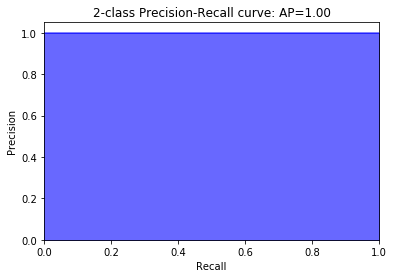

In [104]:

import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
y_true = np.array([0,1,0,1,0,1,0,1,0,1])
y_scores = np.array([0.17,0.87,0.21,0.97,0.34,0.78,0.01,0.76,0.18,0.82])
precision, recall, thresholds = precision_recall_curve(
 y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_true,y_scores)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [111]:
pred

[array([  7.65131295e-01,   3.01365490e-05,   2.25246996e-01,
          1.63817091e-03,   7.93379266e-03,   1.96050278e-05], dtype=float32),
 array([  9.71324623e-01,   9.05238380e-07,   1.62345767e-02,
          3.00299289e-04,   1.06717804e-02,   1.46791013e-03], dtype=float32),
 array([  9.86324012e-01,   1.04937413e-07,   1.15321036e-02,
          2.26347947e-05,   2.05695513e-03,   6.41858496e-05], dtype=float32),
 array([  8.47818851e-01,   2.01393604e-07,   1.51988357e-01,
          1.00151155e-05,   1.75840236e-04,   6.82480550e-06], dtype=float32),
 array([  7.87647784e-01,   2.26952558e-04,   1.54533967e-01,
          5.39391258e-05,   5.61943576e-02,   1.34294247e-03], dtype=float32),
 array([  5.18697143e-01,   4.09882603e-04,   1.59554601e-01,
          1.10901578e-03,   3.07525218e-01,   1.27040930e-02], dtype=float32),
 array([  7.72201717e-01,   3.88795917e-04,   1.62221998e-01,
          9.99257391e-05,   5.61042465e-02,   8.98330100e-03], dtype=float32),
 array([  4.9

In [112]:
print(pr)

[[  6.77788198e-01   2.09584556e-04   1.46186724e-01   1.22663943e-04
    1.74605414e-01   1.08736474e-03]]


In [122]:
for i in pr:
 print(i[0])

0.677788


In [259]:
plot_average_pr_curve(Y_train,(y_score))

NameError: name 'array' is not defined

In [255]:
Y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ..., 
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])